# Construct a custom Environment for Financial Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import csv
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from datetime import date
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from stable_baselines3.common.vec_env import DummyVecEnv

from utils.read2df import read2df

os.makedirs("result/rl-restrict", exist_ok=True)
strategy_txt = f"result/rl-restrict/strategy.txt"
ppo_model = f"ppo_pairtrading.zip"
networth_csv = f"result/rl-restrict/networth.csv"
os.remove(strategy_txt) if os.path.exists(strategy_txt) else None
os.remove(ppo_model) if os.path.exists(ppo_model) else None
os.remove(networth_csv) if os.path.exists(networth_csv) else None

Define data parameters

In [2]:
symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XMRUSDT', 'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'SOLUSDT', 'TRXUSDT']

start_date = '2012-01-01'
trade_date = '2023-01-01'

# freqs = {'1h':60, '2h':120, '4h':240, '6h':360, '8h':480, '12h':720, '1d':1440}
freqs = {'3m':3, '5m':5, '15m':15, '30m':30}

Download data from `binance-public-data`

In [3]:
%%capture
if symbols is None:
    !python binance-public-data/python/download-kline.py -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1
else:
    !python binance-public-data/python/download-kline.py -s {" ".join(symbols)} -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1

In [4]:
# dfs = read2df(symbols, freqs)
dfs = read2df(symbols, freqs)

df0 = dfs[0][dfs[0]['tic']=='BTCUSDT'].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']=='ETHUSDT'].reset_index(drop=True)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [5]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

In [6]:
# Don't use custom observation & action spaces
# See the warning on https://gymnasium.farama.org/api/spaces/

'''
class PairTradingActionSpace(gym.Space):
  def __init__(self, low=-1.0, high=1.0, shape=(2, ), dtype=np.float32):
    super().__init__(shape, dtype)
    self.low = low
    self.high = high

  def sample(self):
    action = np.random.uniform(self.low, self.high, self.shape)
    # Normalize the action so that the summation of action[0] and action[1] is within -1 and 1.
    action = action / np.linalg.norm(action)
    return action

  def contains(self, x):
    return np.all(self.low <= x) and np.all(x <= self.high) and np.linalg.norm(x) <= 1.0
'''

'\nclass PairTradingActionSpace(gym.Space):\n  def __init__(self, low=-1.0, high=1.0, shape=(2, ), dtype=np.float32):\n    super().__init__(shape, dtype)\n    self.low = low\n    self.high = high\n\n  def sample(self):\n    action = np.random.uniform(self.low, self.high, self.shape)\n    # Normalize the action so that the summation of action[0] and action[1] is within -1 and 1.\n    action = action / np.linalg.norm(action)\n    return action\n\n  def contains(self, x):\n    return np.all(self.low <= x) and np.all(x <= self.high) and np.linalg.norm(x) <= 1.0\n'

# Define the custom Environment

The behaviour of RL learner is restricted. 

The action is defined as discrete actions -1, 0, 1

-1 means short df0 long df1, 0 means close position, +1 means long df0 short df1

In [7]:
# The lookback period for the observation space
PERIOD = 100 # Only look at the current price
CASH = 10000

class PairTradingEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    # for pair trading, we need to feed in two OHLCV dataframes
    def __init__(self, df0, df1, tc=0.001):
        super().__init__()

        if not df0['time'].equals(df1['time']):
            raise ValueError("Two dataframe must have same time index")

        self.tic0 = df0['tic'].iloc[0]
        self.tic1 = df1['tic'].iloc[0]

        # transaction cost
        self.tc = tc

        self.df0 = df0[['close', 'datetime']]
        self.df1 = df1[['close', 'datetime']]

        self.reward_range = (-np.inf, np.inf)

        # Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
        # self.action_space = spaces.Dict({
        #     "isAction": spaces.Discrete(2), # Whether we make an action or not (0 or 1)
        #     "amount": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float64)  # Long max 100% or short max 100%
        # })

        # The first one is whether we should action (1) or not (0), the second is whether we should long (0) or short (1)
        self.action_space = spaces.MultiDiscrete([2, 2])

        self.observation_space = spaces.Dict({
            "isPosition": spaces.Discrete(2),  # Whether we have a Position (0 or 1)
            "zscore": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float64)  # Zscore of the spread
        })

        # if the length is 35, then the index shall be 0~34
        self.max_steps = len(df0)-1
    
    def _kellycriterion(self):
        return 1

    def _next_observation(self):
        # The current step is always higher than the PERIOD as defined in the 

        # check if in position
        # self.isPosition = int(self.holding0 == self.holding1 == 0)

        model = sm.OLS(
            df1['close'].iloc[self.current_step-PERIOD+1: self.current_step], 
            sm.add_constant(df0['close'].iloc[self.current_step-PERIOD+1: self.current_step])
        ).fit()

        residuals = model.resid
        zscores = residuals / np.std(residuals)
        
        return {"isPosition": self.isPosition, "zscore": np.array([zscores.iloc[-1]])}

    def _take_action(self, action):

        curr_price0 = self.df0['close'].iloc[self.current_step]
        curr_price1 = self.df1['close'].iloc[self.current_step]
        
        # The first one is whether we should action (1) or not (0), the second is whether we should long (0) or short (1)
        if action[0]:
            
            if self.isPosition: # We shouldn't do any action if we are already holding the position
                self.cash += self.holding0*curr_price0 + self.holding1*curr_price1
                self.holding0 = 0
                self.holding1 = 0
                self.isPosition = 0
            
            elif not self.isPosition: # That means we don't have any position right now
                # evaluate purchasing power 
                max_amount0 = self.cash/curr_price0
                max_amount1 = self.cash/curr_price1

                # We allow the action[1] for long (0) or short (1)
                if action[1]==0:
                    self.holding0 = max_amount0 * self._kellycriterion()
                    self.holding1 = -max_amount1 * self._kellycriterion()
                elif action[1]==1:
                    self.holding0 = -max_amount0
                    self.holding1 = max_amount1

                # if action is 0, then clear out based on curr_holding*curr_price
                # if action is -1, then use all the money to sell df0 and buy df1
                # if action is 1, then use all the money to buy df1 and sell df0
                self.cash -= self.holding0*curr_price0 + self.holding1*curr_price1
                self.isPosition = 1

        # We record the net_worth from previous period to prev_net_worth
        self.prev_net_worth = self.net_worth
        self.net_worth = self.cash + self.holding0*curr_price0 + self.holding1*curr_price1

    def step(self, action):
        self.action = action # for rendering
        self._take_action(action)
        self.current_step += 1

        self.observation = self._next_observation()
        reward = self.net_worth - self.prev_net_worth
        terminated = bool(self.current_step >= self.max_steps)
        truncated = bool(self.net_worth <= 0)
        info = {}

        return self.observation, reward, terminated, truncated, info

    def reset(self, seed=None):
        np.random.seed(seed)
        
        self.cash = CASH
        self.net_worth = CASH
        self.prev_net_worth = CASH
        self.max_net_worth = CASH
        self.isPosition = 0
        self.holding0 = 0
        self.holding1 = 0
        self.render_step = 0

        self.current_step = np.random.randint(PERIOD, self.max_steps)

        return self._next_observation(), {}
    
    def render(self):
        profit = self.net_worth - CASH

        f.write(f"Current step is {self.render_step}\n")
        self.render_step += 1
        f.write(f"Currently {'has a position' if self.observation['isPosition'] else 'no position'} and zscore as: {self.observation['zscore']} \n")
        if self.action[0]:
            f.write(f"Actions for this step: {'Long' if self.action[1] else 'Short'} {self.tic0}, {'Short' if self.action[1] else 'Long'} {self.tic1}\n")
            f.write(f"Current holding is {self.holding0} of {self.tic0} and {self.holding1} of {self.tic1}\n")
        f.write(f"Current net worth is {self.net_worth}, cash is {self.cash}\n\n")

        with open(networth_csv, mode='a', newline='') as csv_f:
            writer = csv.writer(csv_f)
            writer.writerow([self.df0['datetime'].iloc[self.current_step], self.net_worth])

## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [8]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1)
check_env(env)

## Do a test run with random generated actions

In [9]:
env = PairTradingEnv(train0, train1)
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

with open(strategy_txt, "a") as f:
    f.write(f"==== Start random testing ====\n")

    n_steps = 5

    for step in range(n_steps):
        obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
        done = terminated or truncated
        env.render()
        if done:
            break
    
    f.write(f"==== End random testing ====\n\n")

f.close()

observation_space: Dict('isPosition': Discrete(2), 'zscore': Box(-inf, inf, (1,), float64))
action_space: MultiDiscrete([2 2])
action_space.sample: [0 1]


## PPO model from stable_baselines3

Train with training data

In [10]:
from stable_baselines3 import PPO

env = PairTradingEnv(train0, train1)

model = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log="logs")
model.learn(total_timesteps=10000)
model.save("ppo_pairtrading")

## Use the model on Trade data

In [11]:
del model
model = PPO.load("ppo_pairtrading")

In [12]:
os.remove(networth_csv) if os.path.exists(networth_csv) else None

env = PairTradingEnv(test0, test1)

with open(strategy_txt, "a") as f:
    f.write(f"==== Start test trading ====\n")

    env.reset()
    while True:
        action, _states = model.predict(obs)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        env.render()
        if terminated:
            print("Test Finished!")
            break
        elif truncated:
            print("bankrupted!")
            break
    
    f.write(f"==== End test trading ====\n")
    
f.close()

Test Finished!


## Analyze with PyFolio

In [53]:
res = pd.read_csv(networth_csv, names=['datetime', 'returns'])
res['returns'] = res['returns'].pct_change()
res = res.dropna()
res.set_index('datetime', inplace=True)
res.index = pd.to_datetime(res.index)
res = res['returns']

/Users/HSY/miniconda3/envs/uoa-mdt/lib/python3.10/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/HSY/miniconda3/envs/uoa-mdt/lib/python3.10/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2023-04-02
End date,2023-09-30
Total months,4153
,Backtest
Annual return,0.0%
Cumulative returns,14.1%
Annual volatility,0.5%
Sharpe ratio,0.07
Calmar ratio,0.01
Stability,0.92
Max drawdown,-5.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.83,2023-09-06,2023-09-25,NaT,NaN
1,5.60,2023-04-02,2023-04-12,2023-04-14,9
2,3.53,2023-05-13,2023-05-18,2023-05-25,9
3,3.14,2023-04-17,2023-04-24,2023-04-28,10
4,3.12,2023-06-19,2023-06-21,2023-06-23,4


/Users/HSY/miniconda3/envs/uoa-mdt/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/HSY/miniconda3/envs/uoa-mdt/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/HSY/miniconda3/envs/uoa-mdt/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


Stress Events,mean,min,max
New Normal,0.00%,-1.27%,2.21%


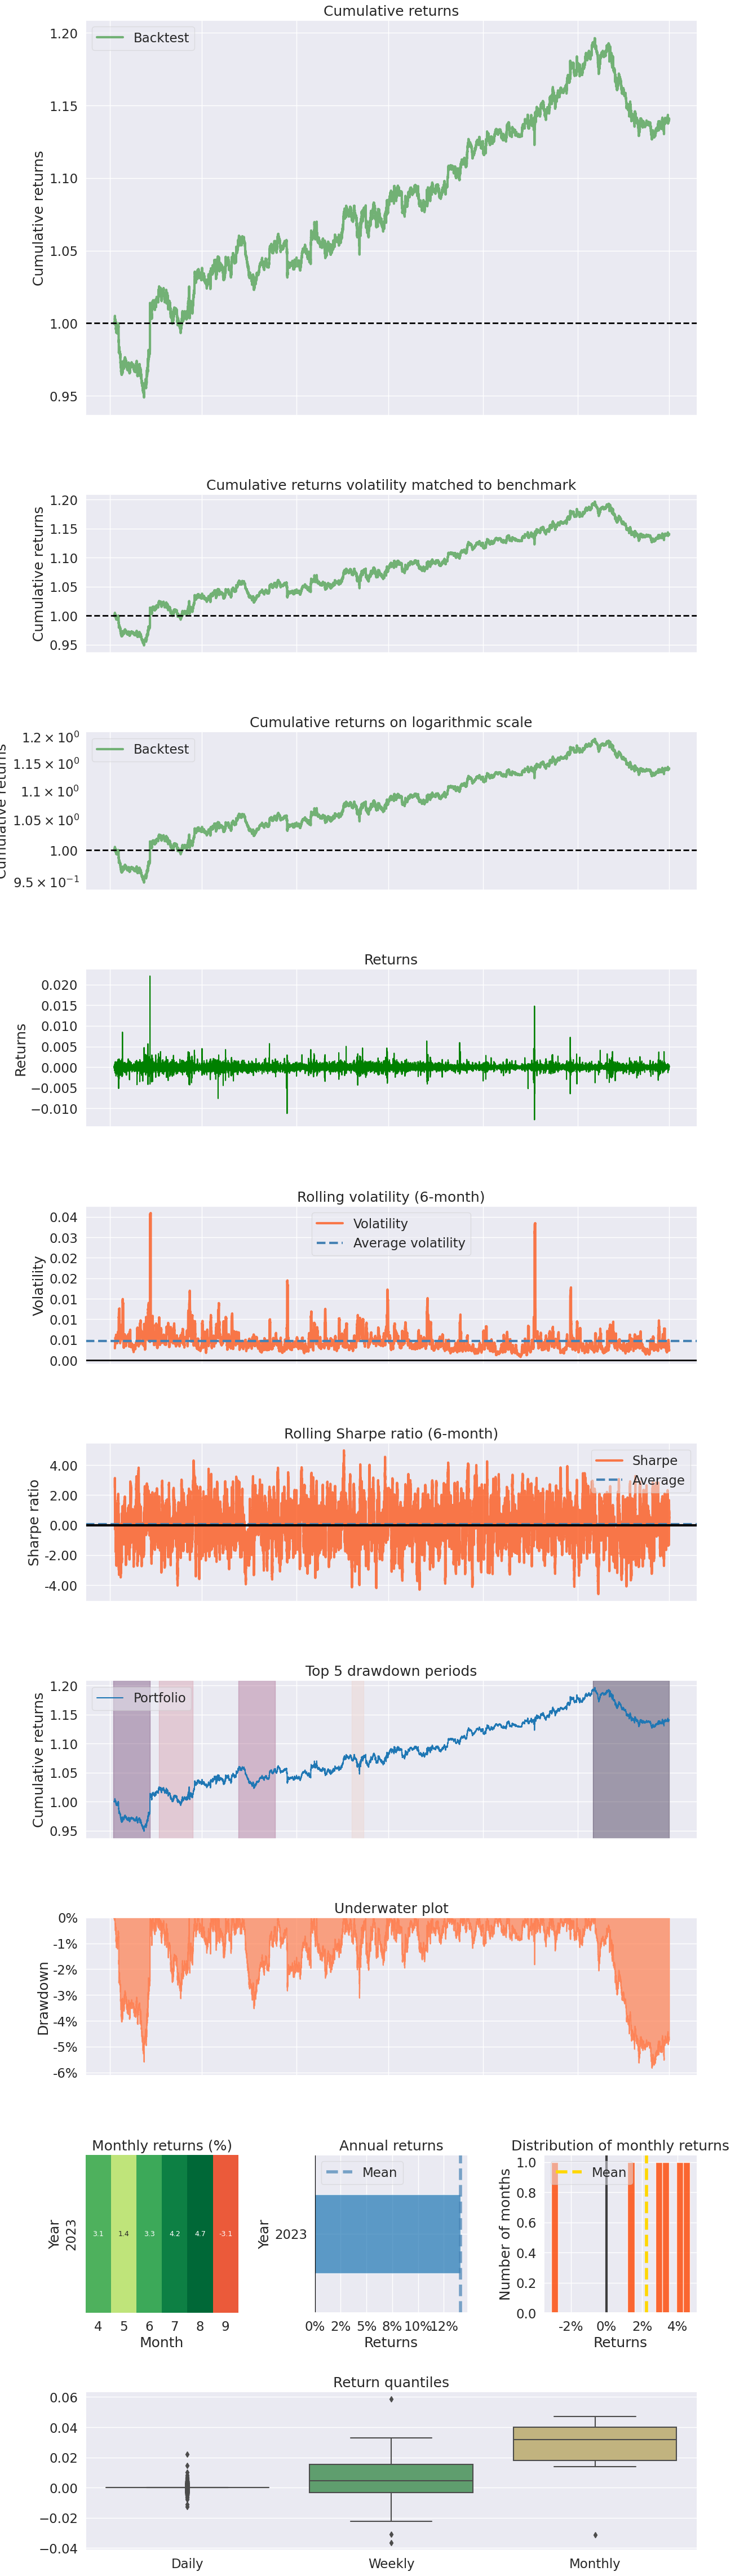

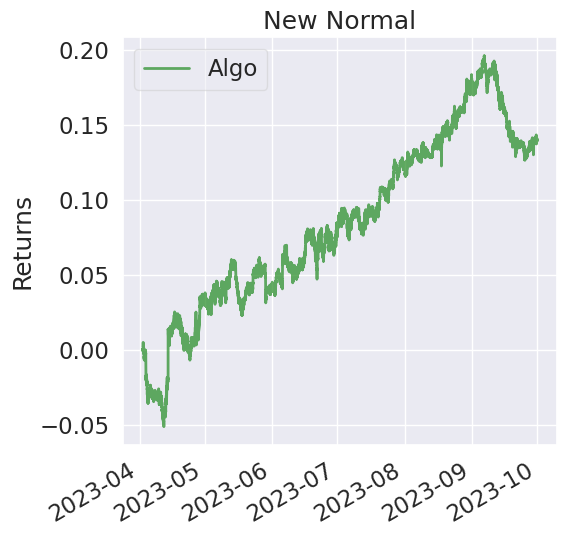

In [58]:
import pyfolio

pyfolio.tears.create_full_tear_sheet(returns)